In [72]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from tensorflow.keras import backend as K
from PIL import Image
import numpy as np
import tensorflow as tf
import pprint
import imageio
import cv2
from tensorflow.keras.applications import vgg19
from tensorflow import keras
from tensorflow import keras
from IPython.display import Image, display
%matplotlib inline

## Name of the images

In [73]:
STYLE_IMAGE_NAME = "el_grito.jpg"
CONTENT_IMAGE_NAME = "amigos2_el_grito.jpeg"
GENERATED_NAME = "amigos2_el_grito"

## Hyperparameter

In [74]:
COLOR_CHANNELS = 3
NOISE_RATIO = 0.6
#coefficient to scale the different errors
TOTAL_VARIATION_COEFF = 1e-6
STYLE_COEFF = 1e-6
CONTENT_COEFF = 2.5e-8
#Path of images
STYLE_PATH = "style_images/van_gogh/"
CONTENT_PATH = "amigos2_el_grito/"
GENERATED_PATH = "generated/"
STYLE_IMAGE_PATH = STYLE_PATH+STYLE_IMAGE_NAME
CONTENT_IMAGE_PATH = STYLE_PATH+CONTENT_PATH+CONTENT_IMAGE_NAME
GENERATED_IMAGE_PATH = STYLE_PATH+CONTENT_PATH+GENERATED_PATH+GENERATED_NAME
BASE_WIDTH ,BASE_HEIGTH = keras.preprocessing.image.load_img(CONTENT_IMAGE_PATH).size
IMG_NROWS = 400
IMG_NCOLS = int(BASE_WIDTH * IMG_NROWS / BASE_HEIGTH)
#IMG_NCOLS = 1024
#IMG_NROWS = int(BASE_HEIGTH* IMG_NCOLS / BASE_WIDTH)
print(BASE_WIDTH ,BASE_HEIGTH)
STYLE_IMAGE_PATH

1280 960


'style_images/van_gogh/el_grito.jpg'

## Style Image

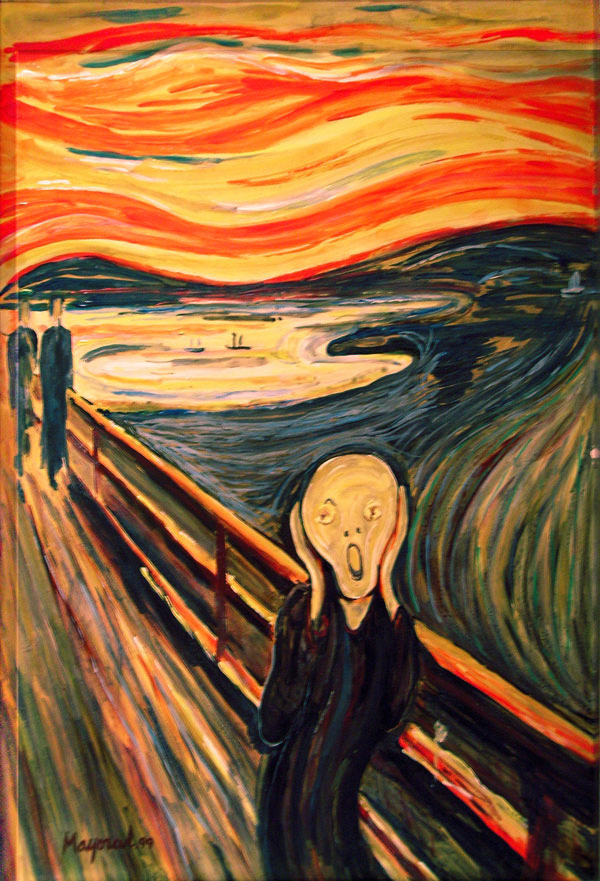

In [75]:
display(Image(STYLE_IMAGE_PATH))

## Content Image

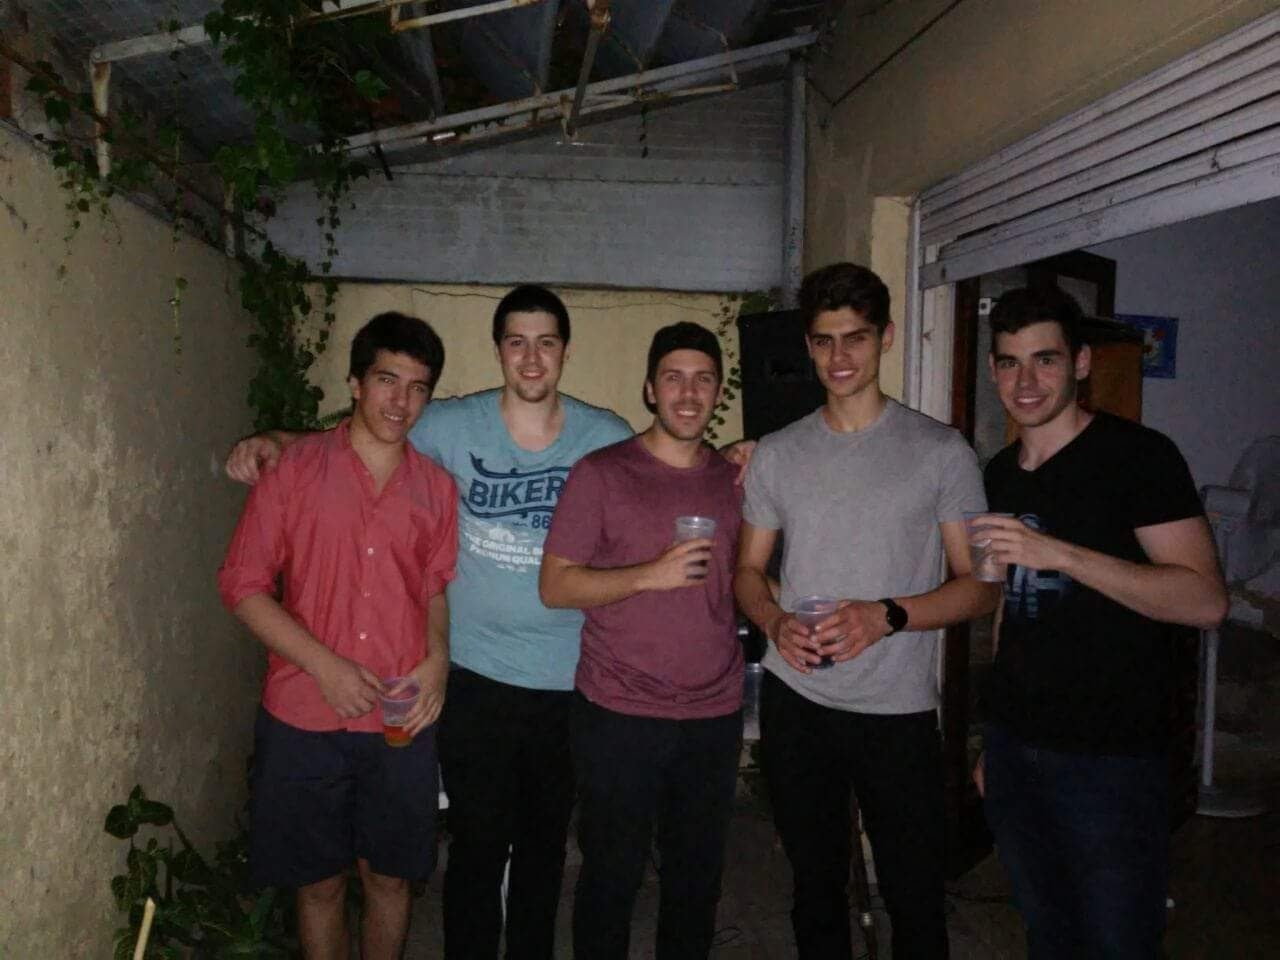

In [76]:
display(Image(CONTENT_IMAGE_PATH))

## Load model pretrained vgg19


In [77]:
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

## Functions for preprocessings images

In [78]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(IMG_NROWS, IMG_NCOLS)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((IMG_NROWS, IMG_NCOLS, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

## Neural Style Transfer (NST)

we will need to define 3 things:

- Build the content cost function $J_{content}(C,G)$
- Build the style cost function $J_{style}(S,G)$
- Build the total variation cost fuction $J_{total_variation}(G)$
- Put it together to get $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$ +  $J_{total variation}(G)$ 

### Content cost

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$


In [79]:
def content_cost(a_C, a_G):
    
    return tf.reduce_sum(tf.square(a_C - a_G))

## Style cost
we need to define:

- Style matrix or Gram matrix
- style_cost

### Style matrix 
* The style matrix is also called a "Gram matrix." 
* In linear algebra, the Gram matrix G of a set of vectors $(v_{1},\dots ,v_{n})$ is the matrix of dot products, whose entries are ${\displaystyle G_{ij} = v_{i}^T v_{j} = np.dot(v_{i}, v_{j})  }$. 
* In other words, $G_{ij}$ compares how similar $v_i$ is to $v_j$: If they are highly similar, you would expect them to have a large dot product, and thus for $G_{ij}$ to be large. 

In [80]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_H, n_W, n_C)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    
    A_T = tf.transpose(A, (2, 0, 1))
    
    A_T_reshaped = tf.reshape(A_T, (tf.shape(A_T)[0], -1))
    
    GA = tf.matmul(A_T_reshaped, tf.transpose(A_T_reshaped))
    
    return GA

## Style_cost

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2\tag{2} $$

In [81]:
def style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value
    """
    G_a_S = gram_matrix(a_S)
    G_a_G = gram_matrix(a_G)
    
    return tf.reduce_sum(tf.square(G_a_S - G_a_G)) / (4.0 * (COLOR_CHANNELS ** 2) * ((IMG_NROWS * IMG_NCOLS) ** 2))

## Total variation cost

In [82]:
def total_variation_cost(a_G):
    a = tf.square(
        a_G[:, : IMG_NROWS - 1, : IMG_NCOLS - 1, :] - a_G[:, 1:, : IMG_NCOLS - 1, :]
    )
    b = tf.square(
        a_G[:, : IMG_NROWS - 1, : IMG_NCOLS - 1, :] - a_G[:, : IMG_NROWS - 1, 1:, :]
    )
    
    total_variation_loss = tf.reduce_sum(tf.pow(a + b, 1.25))
   
    return total_variation_loss * TOTAL_VARIATION_COEFF

## Layers of model VGG19

In [83]:
# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"

## Total Cost
$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$ + J_{total variation}(G)$$

In [84]:
def total_cost(a_S, a_G, a_C):
    
    input_tensor = tf.concat(
        [a_C, a_S, a_G], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    a_C_features = layer_features[0, :, :, :]
    a_G_features = layer_features[2, :, :, :]
    loss = loss + CONTENT_COEFF * content_cost(
        a_C_features, a_G_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        a_S_features = layer_features[1, :, :, :]
        a_G_features = layer_features[2, :, :, :]
        sl = style_cost(a_S_features, a_G_features)
        loss += (STYLE_COEFF / len(style_layer_names)) * sl

    # Add total variation loss
    loss += TOTAL_VARIATION_COEFF * total_variation_cost(a_G)
    return loss

In [85]:
@tf.function
def compute_loss_and_grads(style_image, generated_image, content_image):
    
    with tf.GradientTape() as tape:
        loss = total_cost(style_image, generated_image, content_image)
        
    grads = tape.gradient(loss, generated_image)
    
    return loss, grads

In [87]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)


'''optimizer = keras.optimizers.Adam(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)
'''

content_image = preprocess_image(CONTENT_IMAGE_PATH)
style_image = preprocess_image(STYLE_IMAGE_PATH)
generated_image = tf.Variable(preprocess_image(CONTENT_IMAGE_PATH))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(style_image, generated_image, content_image)
    
    optimizer.apply_gradients([(grads, generated_image)])
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(generated_image.numpy())
        fname = GENERATED_IMAGE_PATH + "_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)


Iteration 100: loss=3430.30
Iteration 200: loss=2302.54
Iteration 300: loss=1858.76
Iteration 400: loss=1608.79
Iteration 500: loss=1443.77
Iteration 600: loss=1324.36
Iteration 700: loss=1232.99
Iteration 800: loss=1160.46
Iteration 900: loss=1100.99
Iteration 1000: loss=1051.13
Iteration 1100: loss=1008.68
Iteration 1200: loss=971.99
Iteration 1300: loss=939.94
Iteration 1400: loss=911.64
Iteration 1500: loss=886.48
Iteration 1600: loss=863.91
Iteration 1700: loss=843.56
Iteration 1800: loss=825.14
Iteration 1900: loss=808.36
Iteration 2000: loss=793.03
Iteration 2100: loss=778.98
Iteration 2200: loss=766.04
Iteration 2300: loss=754.09
Iteration 2400: loss=743.02
Iteration 2500: loss=732.76
Iteration 2600: loss=723.23
Iteration 2700: loss=714.34
Iteration 2800: loss=706.04
Iteration 2900: loss=698.26
Iteration 3000: loss=690.97
Iteration 3100: loss=684.15
Iteration 3200: loss=677.73
Iteration 3300: loss=671.71
Iteration 3400: loss=666.05
Iteration 3500: loss=660.73
Iteration 3600: lo

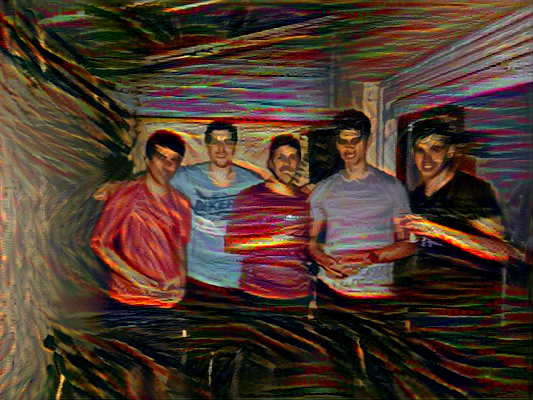

In [88]:
display(Image(GENERATED_IMAGE_PATH+ "_at_iteration_%d.png" % 4000))